In [38]:
import sys
sys.path.append("../../src")

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

## Load and preprocess data

In [41]:
import data

In [63]:
# set db path hackily
data._get_connection("../../data/participants.db")

raw_df = data.get_trials_df(data.load_raw_results(),
                            ("experiment_id", "materials_id", "item_id", "condition_id",
                             "practice_sentence"))

response_df = raw_df[(raw_df.experiment_id == "02_acceptability_swarm") & (raw_df.trial_type == "html-slider-response-with-copout")]

Missing datastring for uid debug9X7NKD:debugKJBC0S. Status was 1.
Missing datastring for uid debugCIT0JY:debugOEXFJU. Status was 1.
Missing datastring for uid debug49IEJI:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJK:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJL:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJM:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJO:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJFP:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJFQ:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJFR:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJFS:debugSVU9KB. Status was 1.
Missing datastring for uid debug49IEJFW:debugSVU9KB. Status was 1.


In [64]:
# Expand condition labels, which are tuples
response_df = pd.concat([response_df, response_df.condition_id.apply(pd.Series).rename(columns=lambda x: f"condition_{x}")], axis=1) \
    .drop(columns="condition_id")

In [65]:
# Norm slider values within-subject.
response_df["slider_zscore"] = \
    response_df.groupby("uniqueid").slider_value.apply(lambda xs: (xs - xs.mean()) / (xs.std(ddof=0)))

In [67]:
response_df.head()

,,condition,counterbalance,assignmentId,workerId,hitId,trial_type,rt,internal_node_id,experiment_id,materials_id,item_id,practice_sentence,survey_question_idx,survey_answer,slider_value,slider_copout,condition_0,condition_1,slider_zscore
trial_index,uniqueid,,,,,,,,,,,,,,,,,,,
1,debug49IEJFT:debugSVU9KB,0,0,debugSVU9KB,debug49IEJFT,debugGB5B3O,html-slider-response-with-copout,2192.2,0.0-1.0,02_acceptability_swarm,None,NaN,1-1,<NA>,NaN,1.0,False,NaN,NaN,-3.051286
2,debug49IEJFT:debugSVU9KB,0,0,debugSVU9KB,debug49IEJFT,debugGB5B3O,html-slider-response-with-copout,1472.1,0.0-2.0,02_acceptability_swarm,None,NaN,4-1,<NA>,NaN,4.0,False,NaN,NaN,-0.711967
3,debug49IEJFT:debugSVU9KB,0,0,debugSVU9KB,debug49IEJFT,debugGB5B3O,html-slider-response-with-copout,1524.6,0.0-3.0,02_acceptability_swarm,None,NaN,7-1,<NA>,NaN,7.0,False,NaN,NaN,1.627352
5,debug49IEJFT:debugSVU9KB,0,0,debugSVU9KB,debug49IEJFT,debugGB5B3O,html-slider-response-with-copout,3685.6,0.0-5.0,02_acceptability_swarm,swarm-002-promptP,2.0,None,<NA>,NaN,7.0,False,0,1,1.627352
6,debug49IEJFT:debugSVU9KB,0,0,debugSVU9KB,debug49IEJFT,debugGB5B3O,html-slider-response-with-copout,1621.9,0.0-6.0,02_acceptability_swarm,swarm-002-promptP,22.0,None,<NA>,NaN,5.0,False,0,1,0.067806


In [68]:
response_df.to_csv("responses.csv")

### Attention checks

In [69]:
subjects_to_drop = set()

#### Practice round

In [70]:
def compute_practice_success(subj_rows):
    """
    Compute fraction of practice sentences for which response equals
    ground truth.
    """
    practice_rows = subj_rows[~subj_rows.practice_sentence.isna()]
    practice_rows[["practice_rating", "practice_idx"]] = practice_rows.practice_sentence.str.split("-", 1, expand=True)
    success = practice_rows["practice_rating"].astype(int) == practice_rows["slider_value"]
    return success.mean()
    
practice_attention_failures = response_df.groupby("uniqueid").apply(compute_practice_success)
practice_attention_failures = practice_attention_failures[practice_attention_failures < 1]
subjects_to_drop |= set(practice_attention_failures.index)

In [71]:
# TODO visualize and drop subjects from `subjects_to_drop`

In [72]:
subjects_to_drop

{'debug49IEJFX:debugSVU9KB'}

### Fillers

In [ ]:
# TODO

## Basic visualization

### Preliminaries

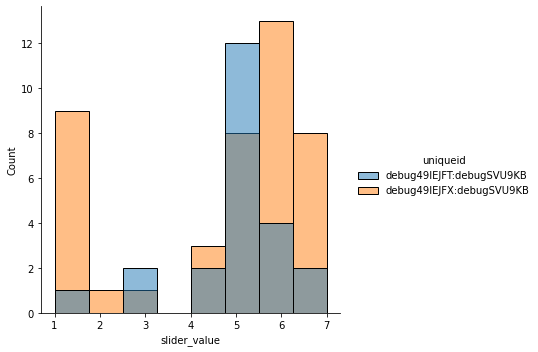

In [73]:
sns.displot(response_df, x="slider_value", hue="uniqueid")

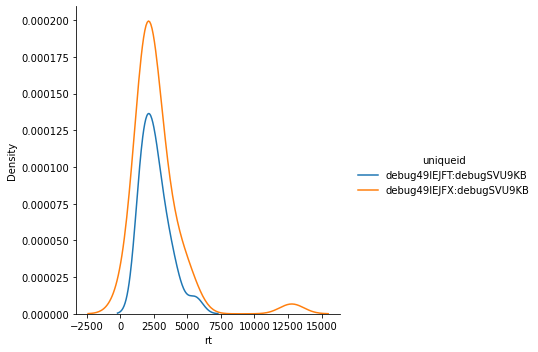

In [74]:
sns.displot(response_df, x="rt", hue="uniqueid", kind="kde")

## Analysis

1. simple t-test to start, bootstrapped over subjects
2. nested bootstrap

In [ ]:
def test_within_subject(rows):
    exp_rows = rows[]